<a href="https://colab.research.google.com/github/mananmehta02/ML_algorithms_from_scratch/blob/main/MyAutograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
def f(x):
  return 3*x*x + 2*x -1

In [87]:
f(1/3)

0.0

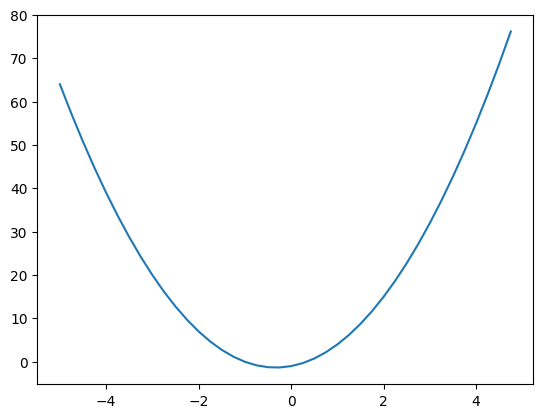

In [88]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [89]:
h = 0.00001
def g(a,b,c):
  return a*b +c
a =2
b=-3
c=10
g(a,b,c)

4

In [90]:
d1 = g(a,b,c)
c += h
d2 = g(a,b,c)
print(d1)
print(d2)
print((d2-d1)/h)

4
4.00001
0.9999999999621422


In [103]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda:None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self) -> str:
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self,other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data* other.data, (self,other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self*other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1-t**2)*out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
    return None

a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')
e = a*b;e.label = 'e'
d = e+c; d.label = 'd'
d._prev
d._op

'+'

In [104]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label = f"{n.label}|data={n.data:.4f}, grad={n.grad:.4f}", shape='record')
    if n._op:
      dot.node(name=uid+n._op, label=n._op)
      dot.edge(uid+n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

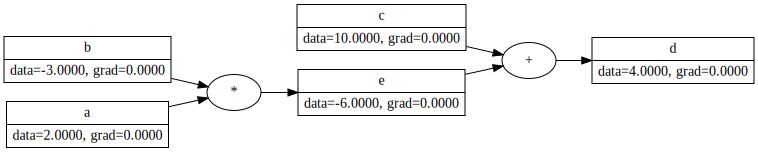

In [105]:
draw_dot(d)

In [106]:
d.backward()

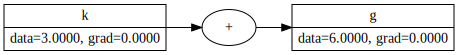

In [107]:
k = Value(3.0, label='k')
g = k+k; g.label='g'
draw_dot(g)



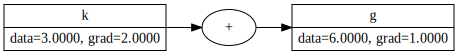

In [108]:
g.backward()
draw_dot(g)

In [109]:
w1 = Value(3.0,label='w1')
w2 = Value(2.0,label='w2')
x1 = Value(1.0, label='x1')
x2 = Value(-1.0,label='x2')
b = Value(0.4,label='b')
x1w1 = w1*x1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 +b; n.label='n'
o = n.tanh();o.label='o'


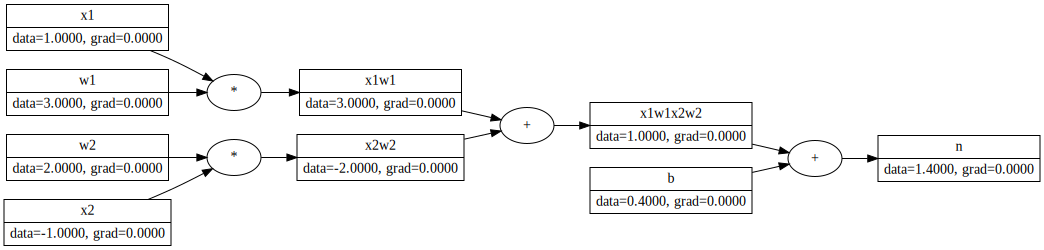

In [110]:
draw_dot(n)

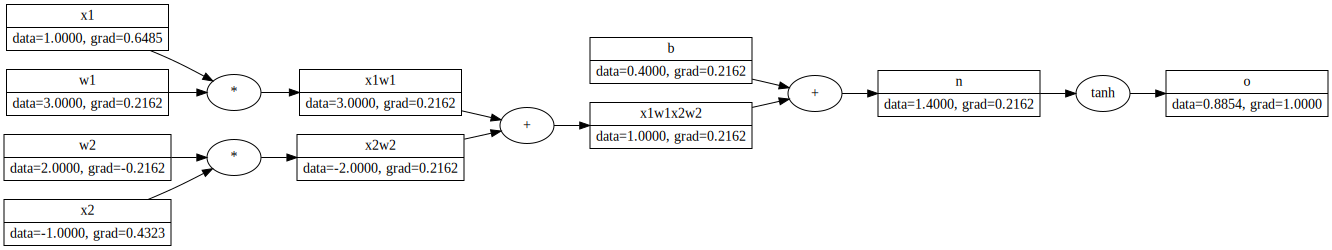

In [111]:
o.backward()
draw_dot(o)

In [112]:
a + 2
a*2
2*a

Value(data=4)

In [136]:
import random

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
    out = act.tanh()
    return out

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

x = [2.0, 3.0, -1.0]
n = MLP(3,[2,1])
n(x)


Value(data=-0.1999655686707895)

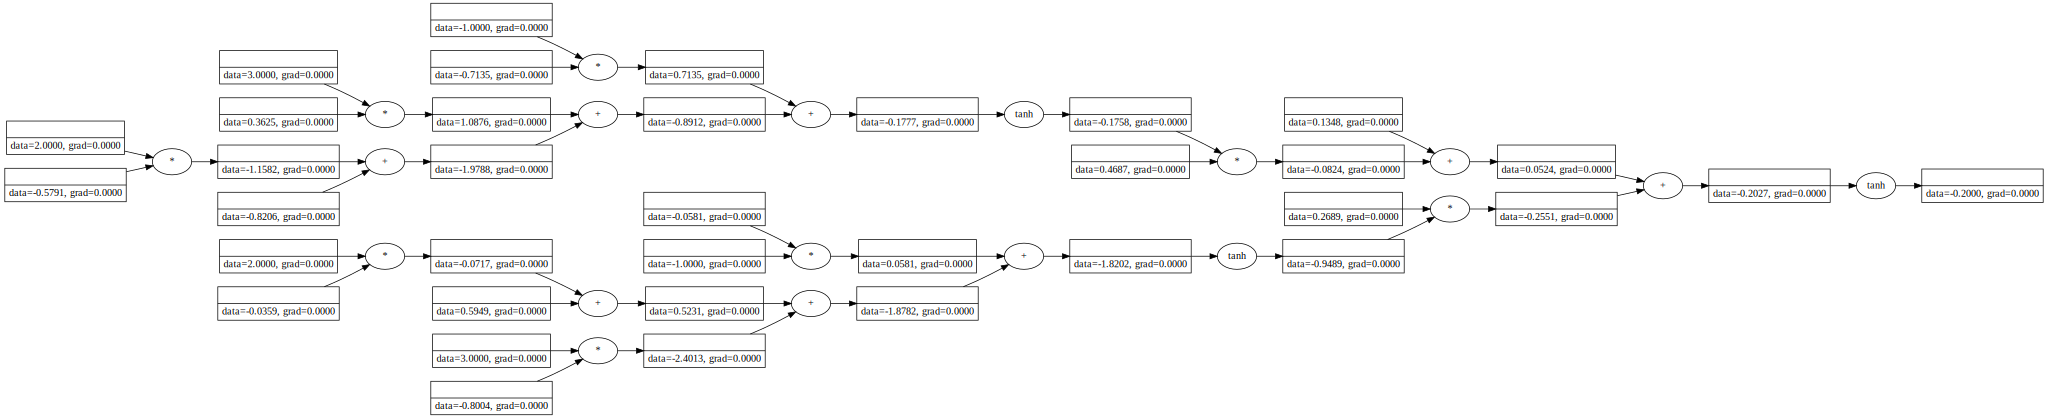

In [137]:
draw_dot(n(x))

In [134]:
n(x).backward()

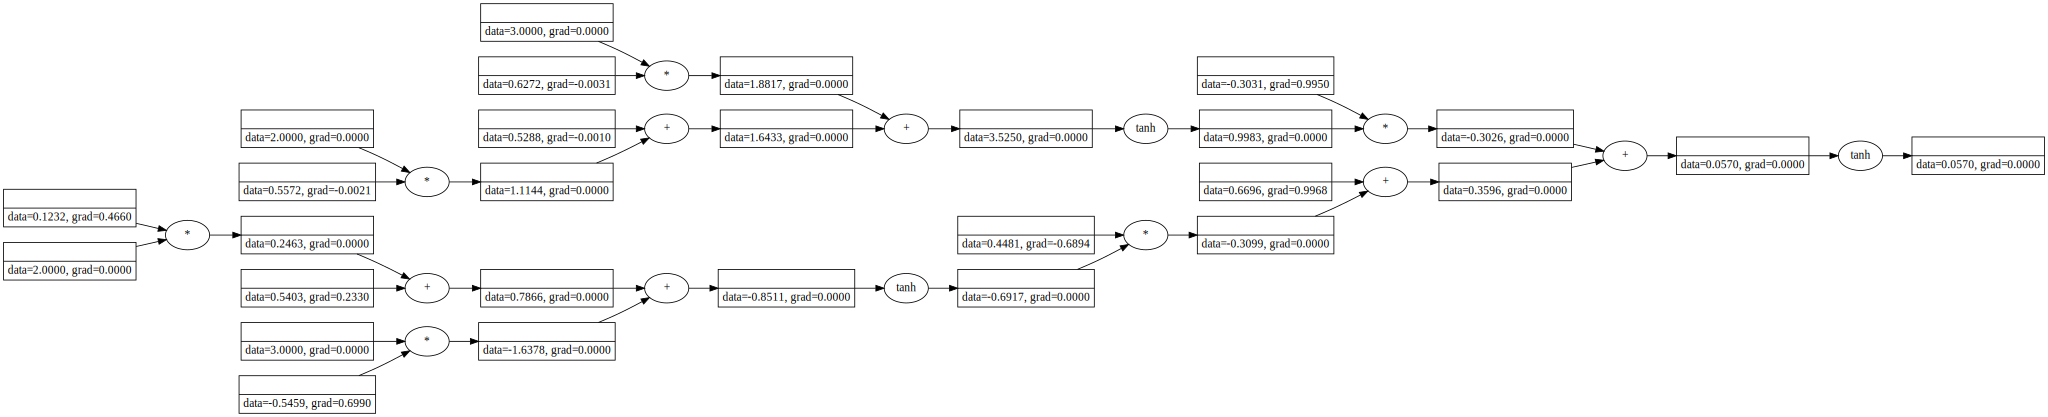

In [135]:
draw_dot(n(x))